In [1]:
## This script computes correlations between pairwise sentence similarities for a variety of models and compares them against each other.
# Requires that sentence similarities have already been computed using 'Cals_sent_sim_[type].ipynb' files.
# Run using base python 3.9
# James Fodor 2023

# load libraries
import numpy as np
import sentence_embeds_processing as sep
import itertools
import seaborn as sns
import os
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# display options
np.set_printoptions(precision=4, threshold=500, linewidth=220, suppress=True, floatmode='fixed')
sns.set()

# base path for all data files
path_root = "D:\Study and Projects\School Work\Year 25 - PhD\Data\\"
data_pairs_path = 'Sentence Similarity Data\\Sentence Similarities Final\\'
data_nonpaired_path = 'Neuroimaging Data\\'
embeddings_path = "Analysis Results\Sentence Embeddings\\"
sims_path = 'Analysis Results\Sentence Similarities\\'

### Load sentence datasets

In [ ]:
## Show available datasets, as specified in the sep module
pairs = False # specify if we are using paired data or list of sentences
if pairs==True:
    datasets = sep.available_pair_datasets
else:
    datasets = sep.available_nonpaired_datasets
print('Available datasets:')
for dataset in datasets.keys():
    print(dataset,datasets[dataset])

In [2]:
## Load sentence set (choose number from those printed above)
dataset = datasets[5]
sentences_dict = sep.load_set_of_sentences(dataset, data_pairs_path, data_nonpaired_path, pairs)
full_dataset_name = sep.fix_sentence_dataset_name(dataset)
n = len(sentences_dict.keys()) # num sentences
print('\nloaded',dataset,'with',n,'sentences')

{0: '2014 Wehbe\\Stimuli\\Chapter_9_sentences_final', 1: '2017 Anderson\\Stimuli\\stimuli_final', 2: '2018 Pereira\\Stimuli\\stimuli_243sentences', 3: '2018 Pereira\\Stimuli\\stimuli_384sentences', 4: '2020 Alice Dataset\\Stimuli\\stimuli_sentences_final', 5: '2023 Fodor Dataset\\Fodor2023-final240', 6: '2023 Fodor Dataset\\Fodor2023-final192', 7: '2023 Fodor Dataset\\Fodor2023-prelim'}

loaded 2023 Fodor Dataset\Fodor2023-final192 with 192 sentences


### Load model sentence similarity data

In [3]:
## Load similarity data for all models for the specified dataset

# all pairs of sentences
print('Dataset:',full_dataset_name)
sent_id_pairs = list(itertools.combinations(sentences_dict.keys(), 2)) 

# loop over all model functions to load data from the storage folder
all_files = os.listdir(path_root+sims_path)
sim_storage,sim_storage_adj = load_model_sims(all_files, full_dataset_name, path_root, sims_path)

print(len(sim_storage),'files loaded')

Fodor2023-final192_amrbart_norml_similarities.txt
Fodor2023-final192_amrbart_similarities.txt
Fodor2023-final192_AMR_similarities.txt
Fodor2023-final192_AMR_WLK_Wasser_similarities.txt
Fodor2023-final192_conv_norml_similarities.txt
Fodor2023-final192_conv_similarities.txt
Fodor2023-final192_defsent_cls_norml_similarities.txt
Fodor2023-final192_defsent_cls_similarities.txt
Fodor2023-final192_defsent_mean_norml_similarities.txt
Fodor2023-final192_defsent_mean_similarities.txt
Fodor2023-final192_ernie_0_norml_similarities.txt
Fodor2023-final192_ernie_0_similarities.txt
Fodor2023-final192_ernie_12_norml_similarities.txt
Fodor2023-final192_ernie_12_similarities.txt
Fodor2023-final192_ernie_5_norml_similarities.txt
Fodor2023-final192_ernie_5_similarities.txt
Fodor2023-final192_GPT4_fixedparms_basic_similarities.txt
Fodor2023-final192_GPT4_fixedparms_norm_similarities.txt
Fodor2023-final192_infersent_norml_similarities.txt
Fodor2023-final192_infersent_similarities.txt
Fodor2023-final192_mean_

### Evaluate sentence pairwise similarities comparing different models

In [5]:
## Models to consider
models =  ['mean','mult','conv','infersent','infersent_norml','universal','universal_norml','ernie_0','ernie_0_norml','ernie_5','ernie_5_norml','ernie_12','ernie_12_norml',
           'amrbart','amrbart_norml','sentbert_mpnet','sentbert_mpnet_norml','openai','openai_norml','defsent_mean','defsent_mean_norml','defsent_cls','defsent_cls_norml',
           'GPT4_fixedparms_basic','GPT4_fixedparms_norm']
models_graph =  ['mean','mult','conv','infersent_norml','universal_norml','ernie_0_norml','ernie_5_norml','ernie_12_norml',
                'amrbart_norml','sentbert_mpnet_norml','openai_norml','defsent_mean_norml','defsent_cls_norml',
                'GPT4_fixedparms_basic','GPT4_fixedparms_norm']
model_names = ['mean','mult','conv','InferSent','Universal','ERNIE_0','ERNIE_5','ERNIE_12',
                'AMRBart','SentBERT','OpenAI','DefSent_mean','DefSent_cls','VerbNet_basic','VerbNet_norm']
model_names_dict = dict(zip(models_graph, model_names))

In [4]:
## Save types of sentence pairs into lists
sent_pair_type = {}

# sets of sentence types
sames_base = np.array([1,2,3])
subs_base = np.array([4,5,6,7,8,9])
mods_base = np.array([10,11,12,13,14,15,16])
swap_base = np.arange(1,17)
len_set = 32
set_numbers = np.arange(0,6) # numbers for each set of sentences

sames_1 = np.array([len_set*set_num+sames_base for set_num in set_numbers])
subs_1 = np.array([len_set*set_num+subs_base for set_num in set_numbers])
mods_1 = np.array([len_set*set_num+mods_base for set_num in set_numbers])
swaps_1 = np.array([len_set*set_num+swap_base for set_num in set_numbers])
sames_2 = sames_1+int(len_set/2)
subs_2 = subs_1+int(len_set/2)
mods_2 = mods_1+int(len_set/2)
swaps_2 = swaps_1+int(len_set/2)

# set defaults
for idx,pair in enumerate(sent_id_pairs):
    sent_pair_type[idx] = 'NONE' 

for idx,pair in enumerate(sent_id_pairs):
    for set_id in set_numbers:
        sent_1,sent_2 = pair # get ids for sentences in pair

        # comparisons within same/para sentences within upper and lower sets
        if (sent_1 in sames_1[set_id] and sent_2 in sames_1[set_id]) or (sent_1 in sames_2[set_id] and sent_2 in sames_2[set_id]):
            sent_pair_type[idx] = 'SAME'

        # adversarial swaps between upper and lower set
        elif sent_1 in swaps_1[set_id] and sent_2==sent_1+int(len_set/2): 
            sent_pair_type[idx] = 'SWAP'

        # word substitutions within upper set
        elif (sent_1 in sames_1[set_id] and sent_2 in subs_1[set_id]) or (sent_1 in subs_1[set_id] and sent_2 in sames_1[set_id]):
            sent_pair_type[idx] = 'SUB'

        # word substitutions within lower set
        elif (sent_1 in sames_2[set_id] and sent_2 in subs_2[set_id]) or (sent_1 in subs_2[set_id] and sent_2 in sames_2[set_id]):
            sent_pair_type[idx] = 'SUB'

        # modifier additions within upper set
        elif (sent_1 in sames_1[set_id] and sent_2 in mods_1[set_id]) or (sent_1 in mods_1[set_id] and sent_2 in sames_1[set_id]):
            sent_pair_type[idx] = 'MOD'

        # modifier additions within lower set
        elif (sent_1 in sames_2[set_id] and sent_2 in mods_2[set_id]) or (sent_1 in mods_2[set_id] and sent_2 in sames_2[set_id]):
            sent_pair_type[idx] = 'MOD'


In [18]:
## Compute and store different subsets of indices for analysis later 

# Store all indices
all_indices = np.arange(len(sent_id_pairs))
print(len(all_indices),'pairs in total')

# Store indices with sentence correlations above a manually-set threshold
threshold = 0.25
indices_above_threshold = {}
for model in models:
    indices_above_threshold[model] = []
    for idx,corr in enumerate(sim_storage_adj[model]):
        if corr>threshold:
            indices_above_threshold[model].append(idx)
print(len(indices_above_threshold['mean']),'pairs above a corr threshold of',str(threshold))

# Store indices for sentences pairs within each set (only relevant for Fodor 2023 dataset)
length_set = 32 # number of sentences in each of the sets
indices_by_set = []
for set_id in np.arange(0,6): # iterate over all 4 sets
    set_indices = list(itertools.combinations(np.arange(set_id*length_set,(set_id+1)*length_set),r=2)) # get all combinations within a set
    indices_by_set+=(set_indices) # add to list

indices_within_sets = []
for idx,sent_pair in enumerate(sent_id_pairs):
    sent_pair_reversed = (sent_pair[1],sent_pair[0]) # need to check both orders
    if sent_pair in indices_by_set or sent_pair_reversed in indices_by_set:
        indices_within_sets.append(idx)

print(len(indices_within_sets),'pairs within each set')

# Store indices for adversarial pairs of sentences (only relevant for Fodor 2023 dataset)
first_parts = []
second_parts = []
for set_id in np.arange(0,8): # iterate over all 4 sets
    if set_id % 2 == 0: # even numbers
        first_parts.append(np.arange(17*set_id,17*(set_id+1)))
    else:
        second_parts.append(np.arange(17*set_id,17*(set_id+1)))

indices_by_set = [] # indices within each set
for set_id in np.arange(0,4): # iterate over all 4 sets
    first_part = first_parts[set_id]
    second_part = second_parts[set_id]
    adversarial_pairs = list(itertools.product(first_part, second_part))
    indices_by_set+=adversarial_pairs

adversarial_indices = [] # indices for the entire set of sentence pairs
for idx,sent_pair in enumerate(sent_id_pairs):
    sent_pair_reversed = (sent_pair[1],sent_pair[0]) # need to check both orders
    if sent_pair in indices_by_set or sent_pair_reversed in indices_by_set:
        adversarial_indices.append(idx)

print(len(adversarial_indices),'adversarial pairs')

18336 pairs in total
3073 pairs above a corr threshold of 0.25
2945 pairs within each set
1139 adversarial pairs


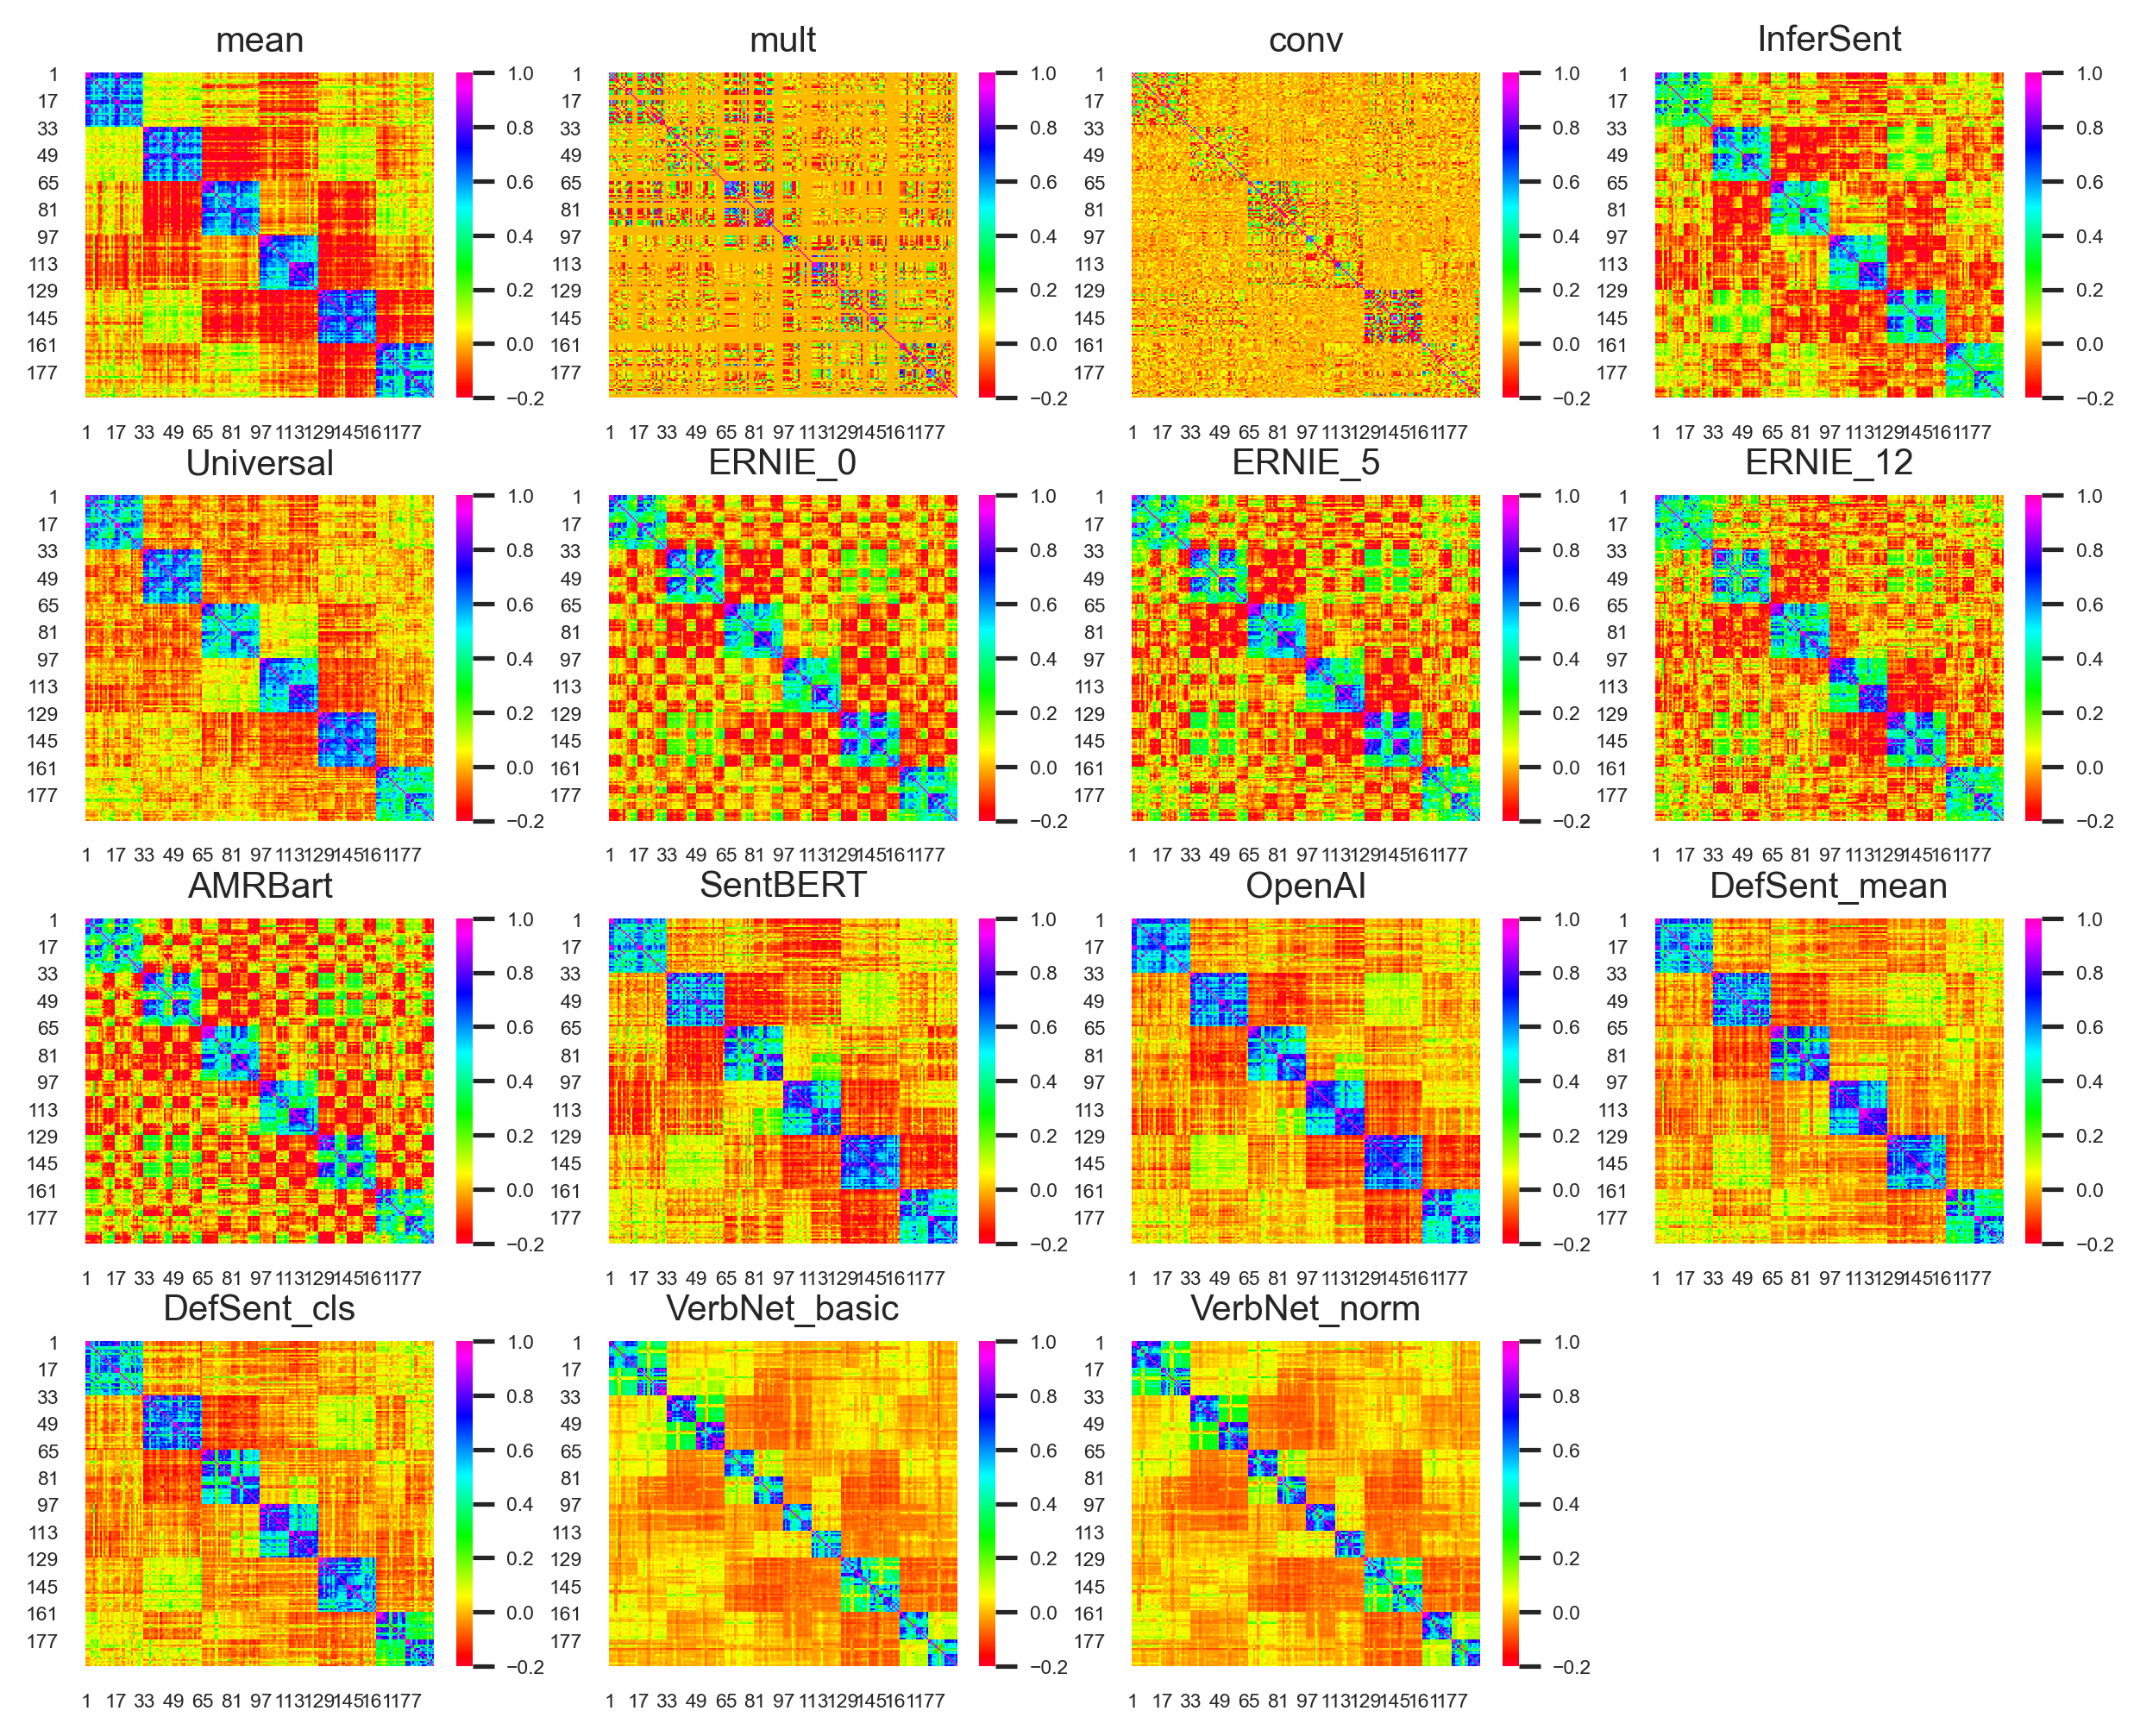

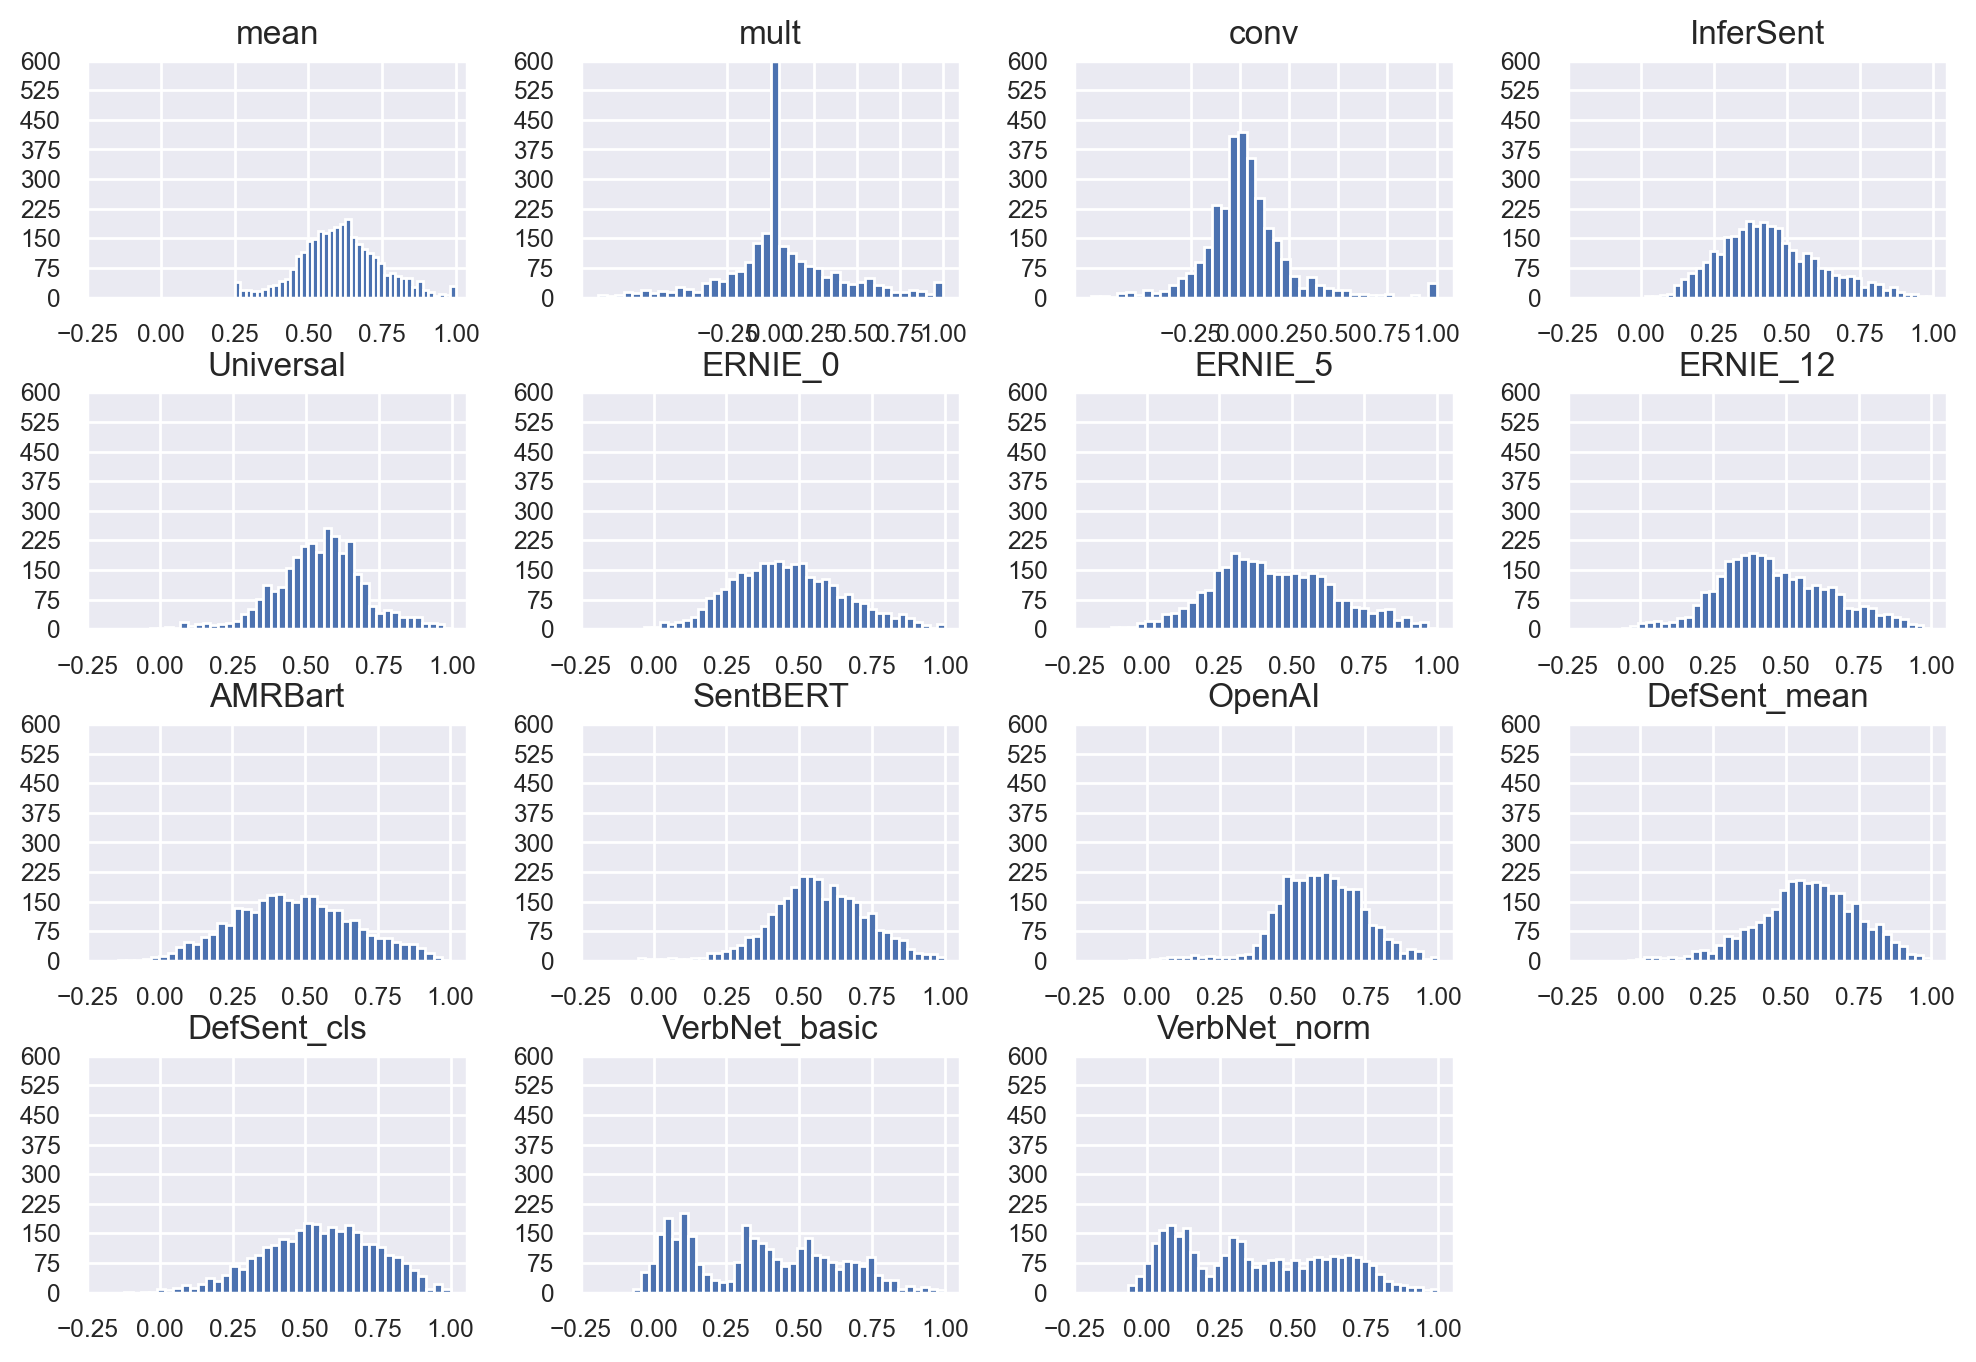

In [8]:
## Compute correlation matrix between model sims

## Choose the set of indices to analyse
# indices_to_include = np.arange(len(sent_id_pairs)) # all pairs
indices_to_include = list(set(indices_above_threshold['mean'])) # threshold
# indices_to_include = indices_within_sets
# indices_to_include = adversarial_indices

# Prepare embeddings and correlations
corr_matrices = {}
for model in models:
    corr_matrices[model] = sep.mask_based_utri2mat(sim_storage_adj[model], len(sentences_dict.keys()))

# Produce RSA heatplot plots for each model
fig = plt.figure(figsize=(10,8), dpi=300)
fig.subplots_adjust(wspace=0.2, hspace=0.3)
for idx,model in enumerate(models_graph):
    plot_num = [4,4,idx+1]
    sns.set(font_scale=0.5)
    fig_axis = fig.add_subplot(*plot_num)
    ax = sns.heatmap(corr_matrices[model], vmin=-0.2, vmax=1, cmap="gist_rainbow", ax=fig_axis)
    ax.set_title(model_names_dict[model], fontsize=10)
    
    ticks_range = np.arange(0,n,step=int(n/12))
    label_range = np.arange(1,n+1,step=int(n/12))
    ax.set_xticks(ticks_range, minor=False)
    ax.set_xticks(ticks_range+0.5, minor=True)
    ax.set_xticklabels('', minor=False)
    ax.set_xticklabels(label_range, minor=True)
    ax.set_yticks(ticks_range, minor=False)
    ax.set_yticks(ticks_range+0.5, minor=True)
    ax.set_yticklabels('', minor=False)
    ax.set_yticklabels(label_range, minor=True)
    
plt.show()

# Produce histogram subplots for each model
fig = plt.figure(figsize=(12,8), dpi=200)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
for idx,model in enumerate(models_graph):
    plot_num = [4,4,idx+1]
    
    # Print histogram of sentence similarities and correlation matrix
    max_value=600
    sns.set(font_scale=0.8)
    ax = fig.add_subplot(*plot_num)
    ax.hist(sim_storage_adj[model][indices_to_include], bins=40)
    ax.set_xticks([-0.25,0,0.25,0.5,0.75,1])
    ax.set_yticks(np.arange(0,max_value+1,step=max_value/8))
    ax.set_ylim(0,max_value)
    ax.set_title(model_names_dict[model], fontsize=12)
    
plt.show()

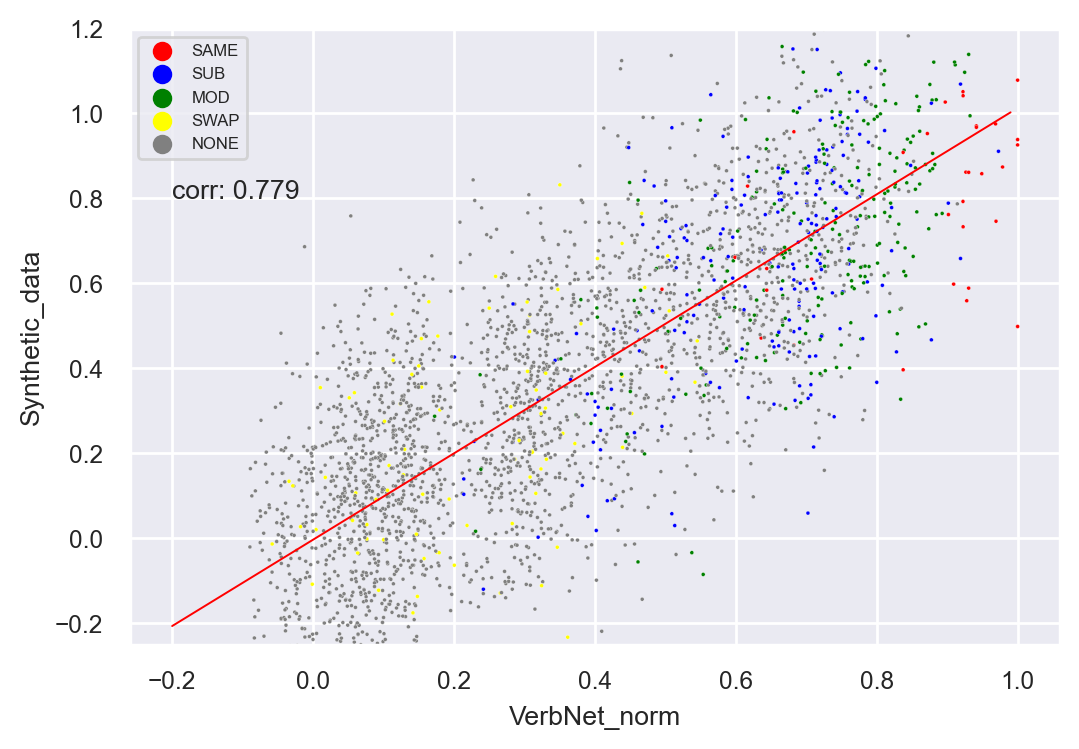

In [20]:
## Produce a scatterplot comparing two models

# generate synthetic data based on the VerbNet parse
sim_storage_adj['fake_data'] = sim_storage_adj['GPT4_fixedparms_norm'] + np.random.normal(0, 0.22, size=len(sim_storage_adj['mean']))
model_names_dict['fake_data'] = 'Synthetic_data'

# specify data and parameters
# ['mean','ernie_12_norml','sentbert_mpnet_norml','defsent_mean_norml','openai_norml', 'GPT4_fixedparms_norm', 'GPT4_fixedparms_basic']
model_1 = 'GPT4_fixedparms_norm'
model_2 = 'fake_data'

# choose set of indices to analyse
threshold_indices = indices_above_threshold['mean'] 
indices_to_use = [threshold_indices, adversarial_indices, indices_within_sets, all_indices]
indices = indices_within_sets
xs = sim_storage_adj[model_1][indices] 
ys = sim_storage_adj[model_2][indices]
color_values = np.array(list(sent_pair_type.values()))[indices]

# plot regression line
xs_poly = PolynomialFeatures(degree=1, include_bias=True).fit_transform(xs.reshape(-1, 1))
poly_regression = LinearRegression()
poly_regression.fit(xs_poly, ys)
x_range = np.arange(-0.2,1, step=0.01)
x_range_poly = PolynomialFeatures(degree=1, include_bias=True).fit_transform(x_range.reshape(-1, 1))
pred_ys = poly_regression.predict(x_range_poly)
r2 = r2_score(ys, poly_regression.predict(xs_poly))

# plot scatterplot figure
plt.figure(figsize=(6,4), facecolor='white', dpi=200)
plt.plot(x_range, pred_ys, color='red', linewidth=0.7) # add reg line
plt.text(-0.2, 0.8, 'corr: {:.3f}'.format(np.sqrt(r2))) # add label with corr
plot_data = {'X':list(xs), 'Y':list(ys), 'Cat':color_values}
color_mapping = {'SAME': 'red', 'SUB': 'blue', 'MOD': 'green', 'SWAP': 'yellow', 'NONE': 'grey'}
sns.scatterplot(data=plot_data, x='X', y='Y', hue='Cat', s=2, palette=color_mapping)
plt.xlabel(model_names_dict[model_1])
try:
    plt.ylabel(model_names_dict[model_2])
except KeyError:
    plt.ylabel('Simulated data')
plt.ylim(-0.25,1.2)
plt.legend(loc='upper left', fontsize=6)
plt.show()

### Further Analyses (archive, feel free to ignore!)

-0.02756397710947746


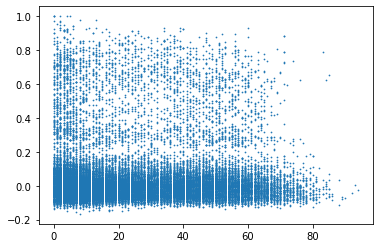

In [27]:
## Examine the relationship between sentence length and similarities

# Compute vector of length differences
length_diffs = []
for pair in sent_id_pairs:
    length_diff = len(sentences_dict[pair[0]])-len(sentences_dict[pair[1]])
    length_diffs.append(np.abs(length_diff))

# Print lengths scatterplot
model_for_lengths = 'GPT4_fixedparms_norm'
print(np.corrcoef(length_diffs,sim_storage_adj[model_for_lengths])[0,1])
plt.scatter(length_diffs,sim_storage_adj[model_for_lengths], s=0.5)
plt.show()


In [175]:
# Print sentence pairs with biggest differences in the similarities assigned by the two models
for idx,x in enumerate(xs):
    if 0.2<ys[idx]<0.4 and 0.25<xs[idx]<0.35:
        # full_sent_index = indices_within_sets[idx] # need to adjust if we are only using the within_sets indices
        full_sent_index = idx # use this if we are using all indices
        sent_1_idx,sent_2_idx = sent_id_pairs[full_sent_index] # get indices for each sentence in the sentence_dict
        print(full_sent_index,sentences_dict[sent_1_idx],sentences_dict[sent_2_idx],xs[idx],ys[idx])

951 The videographer carried his camera over to the producer. The small child brought the equipment to the director. 0.27372631994907903 0.3714529204776411
2100 The cameraman repaired the equipment for the director. The surveillance camera watched over the display for the shopkeeper. 0.2558064504027282 0.23255340664093058
2512 The cameraman brought important documents to the director. In a confidential meeting the lobbyist wrote a short memo to the politician about the investigative journalist. 0.2810893479943627 0.2161232497985298
2794 Every morning the cameraman brought the equipment to the impatient director. Every day the customer watched over the display for the shopkeeper during lunch. 0.34930615215507377 0.246921162685264
3240 The cameraman brought the equipment across the busy street to the director at his residence. The surveillance camera watched over the display for the shopkeeper. 0.25038922256778107 0.20893846322975598
3912 Under close scrutiny a cameraman brought the conf

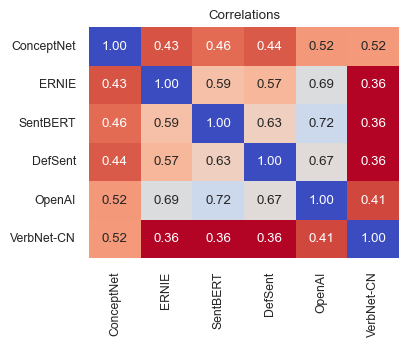

In [ ]:
## Compute correlation matrix between models
model_correl_pairs = np.zeros((len(models),len(models)))
for i,model_1 in enumerate(models):
    for j,model_2 in enumerate(models):

        # compute correlations
        pearson_corr = np.corrcoef(sim_storage[model_1][indices_to_include],sim_storage[model_2][indices_to_include])[0,1]
        spearman_corr = spearmanr(sim_storage[model_1][indices_to_include],sim_storage[model_2][indices_to_include]).correlation

        # store correlation in matrix
        model_correl_pairs[i,j] = spearman_corr

# Plot results
fig, axis = plt.subplots(figsize=(4,3), facecolor='white', dpi=100)
plt.title('Correlations')
sns.heatmap(model_correl_pairs, annot=True, fmt='.2f', ax=axis, cmap='coolwarm_r', cbar=False, xticklabels=model_names, yticklabels=model_names)
plt.show()